# 4 Modeling<a id='4_Modeling'></a>

## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Modeling](#3_Modeling)
  * [4.1 Imports](#4.1_Imports)
  * [4.2 Load Data](#4.4_Load_Data)
  * [4.5 One-Hot Encoding](#4.5_One-Hot_Encoding)
  * [4.6 XGBoost Classifier](#4.6_XGBoost_Classifier)
      * [4.6.1 Initial Fit](#4.6.1_Initial_Fit)
      * [4.6.2 ](#4.6.2_)
      * [4.6.3 ](#4.6.3_)
  * [4.7 Bernoulli Naive Bayes](#4.7_Bernoulli_Naive_Bayes)
  * [4.8 Linear Discriminant Analysis](#4.8_Linear_Discriminant_Analysis)
  * [4.8 Optimizing XGBoost](#4.9_Optimizing_XGBoost)

## 4.3 Imports<a id='4.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.max_columns',50)

## 4.4 Load Data<a id='4.4_Load_Data'></a>

In [2]:
df_encoded = pd.read_csv('../data/processed/df_encoded.csv', index_col=0)

We first load in the encoded dataset. We will not review with .head() since there are many columns now created from the one-hot encoding.

## 4.5 Reviewing Superficial Modeling<a id='4.5_Reviewing_Superficial_Modeling'></a>

In [3]:
models = pd.read_csv('../data/processed/lazypredict_models.csv')

In [4]:
models.sort_values(['F1 Score','Accuracy'], ascending=False)

,Model,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
7,XGBClassifier,0.843711,0.524447,0.524447,0.793367,0.308411
8,BernoulliNB,0.839963,0.520258,0.520258,0.790074,0.112741
10,LinearDiscriminantAnalysis,0.847772,0.513255,0.513255,0.787993,0.358339
9,BaggingClassifier,0.840796,0.515372,0.515372,0.787655,6.418692
12,LGBMClassifier,0.849229,0.510434,0.510434,0.786488,0.335969
13,AdaBoostClassifier,0.848501,0.509722,0.509722,0.785910,2.571018
11,KNeighborsClassifier,0.834444,0.511630,0.511630,0.783982,0.923021
15,CalibratedClassifierCV,0.848605,0.506104,0.506104,0.783566,2.037228
16,LogisticRegression,0.847876,0.505957,0.505957,0.783369,0.329325
18,ExtraTreesClassifier,0.847876,0.502844,0.502844,0.781284,5.393083


## 4.6 XGBoost Classifier<a id='4.6_XGBoost_Classifier'></a>

In [5]:
X = df_encoded.drop(columns=['earliest_cr_line','repay_fail'])
y = df_encoded.repay_fail

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

### 4.6.1 Initial Fit<a id='4.6.1_Initial_Fit'></a>

In [6]:
xgb_model = XGBClassifier(random_state=42)

xgb_model.fit(X_train, y_train)

# Predict on test data
xgb_predictions = xgb_model.predict(X_test)

# Optionally, get prediction probabilities
xgb_probs = xgb_model.predict_proba(X_test)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test, xgb_predictions,output_dict=True)).T)
print("XGBoost AUC: ", roc_auc_score(y_test, xgb_probs))

,precision,recall,f1-score,support
0,0.855251,0.982090,0.914292,8152.000000
1,0.399177,0.066804,0.114454,1452.000000
accuracy,0.843711,0.843711,0.843711,0.843711
macro avg,0.627214,0.524447,0.514373,9604.000000
weighted avg,0.786298,0.843711,0.793367,9604.000000


XGBoost AUC:  0.6877861438454489


Based on the accuracy of the initial fit, it is evident the model is as good at randomly guessing which loans defaulted because the amount of defaulted loans is 15%, and the accuracy of the model is 85%.

In [7]:
df_encoded.repay_fail.value_counts(normalize=True)

0    0.848835
1    0.151165
Name: repay_fail, dtype: float64

Here we confirm our suspicion by displaying the proportion of defaulted and non-defaulted loans.

### 4.6.2 Oversampling<a id='4.6.2_Oversampling'></a>

In [8]:
df_encoded.repay_fail.value_counts()

0    32608
1     5807
Name: repay_fail, dtype: int64

In [9]:
df_encoded.repay_fail.value_counts(normalize=True)

0    0.848835
1    0.151165
Name: repay_fail, dtype: float64

We can see that only 15% of the loans in our dataset are defaults, which may explain why our model isn't good at predicting defaults.

In [10]:
#create two different dataframe of majority and minority class 
df_majority = df_encoded[df_encoded['repay_fail']==0]
df_minority = df_encoded[df_encoded['repay_fail']==1]

# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples= 32608,
                                 random_state=42)

df_upsampled = pd.concat([df_minority_upsampled, df_majority])

In [11]:
df_upsampled['repay_fail'].value_counts()

1    32608
0    32608
Name: repay_fail, dtype: int64

In [12]:
X_over = df_upsampled.drop(columns=['earliest_cr_line','repay_fail'])
y_over = df_upsampled.repay_fail

In [13]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_over, y_over, test_size=0.25, random_state=42)

In [14]:
xgb_over = XGBClassifier(random_state=42)

xgb_over.fit(X_train_o, y_train_o)

# Predict on test data
xgb_predictions_over = xgb_over.predict(X_test_o)

# Optionally, get prediction probabilities
xgb_probs_over = xgb_over.predict_proba(X_test_o)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test_o, xgb_predictions_over,output_dict=True)).T)
print("XGBoost AUC: ", roc_auc_score(y_test_o, xgb_probs_over))

,precision,recall,f1-score,support
0,0.828905,0.747433,0.786063,8180.000000
1,0.768593,0.844658,0.804832,8124.000000
accuracy,0.795878,0.795878,0.795878,0.795878
macro avg,0.798749,0.796045,0.795448,16304.000000
weighted avg,0.798852,0.795878,0.795416,16304.000000


XGBoost AUC:  0.8751213615608435


This is a remarkable improvement to the model!

### 4.6.3 Cross Validation<a id='4.6.3_Cross_Validation'></a>

In [15]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'min_child_weight': [1, 5],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5],
}

xgb_over_2 = XGBClassifier(random_state=42)

xgb_over_2.fit(X_train_o, y_train_o)

# Initialize the GridSearchCV object
xgb_grid_search = GridSearchCV(estimator=xgb_over_2, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=1)

# Fit the grid search to the data
xgb_grid_search.fit(X_train_o, y_train_o)

# Print the best parameters found
print("Best parameters found: ", xgb_grid_search.best_params_)
print("Best F1 found: ", xgb_grid_search.best_score_)

Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
Best F1 found:  0.7796344072993517


## 4.7 Bernoulli Naive Bayes<a id='4.7_Bernoulli_Naive_Bayes'></a>

### 4.7.1 Initial Fit<a id='4.7.1_Initial_Fit'></a>

In [16]:
bnb_model = BernoulliNB()

bnb_model.fit(X_train, y_train)

# Predict on test data
bnb_predictions = bnb_model.predict(X_test)

# Optionally, get prediction probabilities
bnb_probs = bnb_model.predict_proba(X_test)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test, bnb_predictions,output_dict=True)).T)
print("BernoulliNB AUC: ", roc_auc_score(y_test, bnb_probs))

,precision,recall,f1-score,support
0,0.848911,0.999387,0.918024,8152.000000
1,0.285714,0.001377,0.002742,1452.000000
accuracy,0.848501,0.848501,0.848501,0.848501
macro avg,0.567313,0.500382,0.460383,9604.000000
weighted avg,0.763763,0.848501,0.779645,9604.000000


BernoulliNB AUC:  0.6089592592667689


### 4.7.2 Oversampling<a id='4.7.2_Oversampling'></a>

In [17]:
bnb_model_over = BernoulliNB()

bnb_model_over.fit(X_train_o, y_train_o)

# Predict on test data
bnb_predictions_over = bnb_model_over.predict(X_test_o)

# Optionally, get prediction probabilities
bnb_probs_over = bnb_model_over.predict_proba(X_test_o)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test_o, bnb_predictions_over,output_dict=True)).T)
print("BernoulliNB AUC: ", roc_auc_score(y_test_o, bnb_probs_over))

,precision,recall,f1-score,support
0,0.575062,0.597066,0.585857,8180.000000
1,0.578031,0.555761,0.566677,8124.000000
accuracy,0.576484,0.576484,0.576484,0.576484
macro avg,0.576546,0.576413,0.576267,16304.000000
weighted avg,0.576541,0.576484,0.576300,16304.000000


BernoulliNB AUC:  0.6114555457041769


### 4.7.3 Cross Validation<a id='4.7.3_Cross_Validation'></a>

In [18]:
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0],
    'binarize': [0.0, 0.1, 0.2, 0.5]
}

bnb_over_2 = BernoulliNB()

bnb_over_2.fit(X_train_o, y_train_o)

# Initialize the GridSearchCV object
bnb_grid_search = GridSearchCV(estimator=bnb_over_2, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=1)

# Fit the grid search to the data
bnb_grid_search.fit(X_train_o, y_train_o)

# Print the best parameters found
print("Best parameters found: ", bnb_grid_search.best_params_)
print("Best F1 found: ", bnb_grid_search.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found:  {'alpha': 1.0, 'binarize': 0.5}
Best F1 found:  0.5652814260222789


## 4.8 Linear Discriminant Analysis<a id='4.8_Linear_Discriminant_Analysis'></a>

### 4.8.1 Initial Fit<a id='4.8.1_Initial_Fit'></a>

In [19]:
lda_model = LinearDiscriminantAnalysis()

lda_model.fit(X_train, y_train)

# Predict on test data
lda_predictions = lda_model.predict(X_test)

# Optionally, get prediction probabilities
lda_probs = lda_model.predict_proba(X_test)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test, lda_predictions,output_dict=True)).T)
print("LinearDiscriminantAnalysis AUC: ", roc_auc_score(y_test, lda_probs))

,precision,recall,f1-score,support
0,0.852254,0.992763,0.917158,8152.000000
1,0.453704,0.033747,0.062821,1452.000000
accuracy,0.847772,0.847772,0.847772,0.847772
macro avg,0.652979,0.513255,0.489989,9604.000000
weighted avg,0.791998,0.847772,0.787993,9604.000000


LinearDiscriminantAnalysis AUC:  0.7136600695599046


### 4.8.2 Oversampling<a id='4.8.2_Oversampling'></a>

In [20]:
lda_over = LinearDiscriminantAnalysis()

lda_over.fit(X_train_o, y_train_o)

# Predict on test data
lda_predictions_over = lda_over.predict(X_test_o)

# Optionally, get prediction probabilities
lda_probs_over = lda_over.predict_proba(X_test_o)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test_o, lda_predictions_over,output_dict=True)).T)
print("LinearDiscriminantAnalysis AUC: ", roc_auc_score(y_test_o, lda_probs_over))

,precision,recall,f1-score,support
0,0.647655,0.656601,0.652097,8180.000000
1,0.649357,0.640325,0.644809,8124.000000
accuracy,0.648491,0.648491,0.648491,0.648491
macro avg,0.648506,0.648463,0.648453,16304.000000
weighted avg,0.648503,0.648491,0.648466,16304.000000


LinearDiscriminantAnalysis AUC:  0.7044071927904763


### 4.8.3 Cross Validation<a id='4.8.3_Cross_Validation'></a>

In [21]:
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.0, 0.5, 1.0],
    'tol': [0.0001, 0.0002, 0.0005]
}

lda_over_2 = LinearDiscriminantAnalysis()

lda_over_2.fit(X_train_o, y_train_o)

# Initialize the GridSearchCV object
lda_grid_search = GridSearchCV(estimator=lda_over_2, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=1)

# Fit the grid search to the data
lda_grid_search.fit(X_train_o, y_train_o)

# Print the best parameters found
print("Best parameters found: ", lda_grid_search.best_params_)
print("Best F1 found: ", lda_grid_search.best_score_)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Best parameters found:  {'shrinkage': None, 'solver': 'lsqr', 'tol': 0.0001}
Best F1 found:  0.6463892121558846


In [22]:
lda_best_model = lda_grid_search.best_estimator_
lda_predictions_cv = lda_best_model.predict(X_test_o)
lda_probs_cv = lda_best_model.predict_proba(X_test_o)[:,1]

display(pd.DataFrame(classification_report(y_test_o, lda_predictions_cv,output_dict=True)).T)
print("LinearDiscriminantAnalysis AUC: ", roc_auc_score(y_test_o, lda_probs_cv))

,precision,recall,f1-score,support
0,0.647045,0.657090,0.652029,8180.000000
1,0.649243,0.639094,0.644129,8124.000000
accuracy,0.648123,0.648123,0.648123,0.648123
macro avg,0.648144,0.648092,0.648079,16304.000000
weighted avg,0.648140,0.648123,0.648092,16304.000000


LinearDiscriminantAnalysis AUC:  0.7044032953764331


## 4.9 Optimizing XGBoost<a id='4.9_Optimizing_XGBoost'></a>

In [23]:
potential_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.05, 0.1, 0.2, 0.3],
    'reg_lambda': [0.8, 1.0, 1.2, 1.5, 1.7],
    }

param_dict = {}

for param, values in potential_grid.items():
    
    optimal_params = {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 
                  'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
    
    if param not in param_dict:
        param_dict[param] = {}
    
    for value in values:
        
        optimal_params[param] = value

        xgb_temp = XGBClassifier(**optimal_params, random_state=42)

        xgb_temp.fit(X_train_o, y_train_o)

        xgb_pred_over = xgb_temp.predict(X_test_o)

        
        param_dict[param][value] = f1_score(y_test_o, xgb_pred_over)

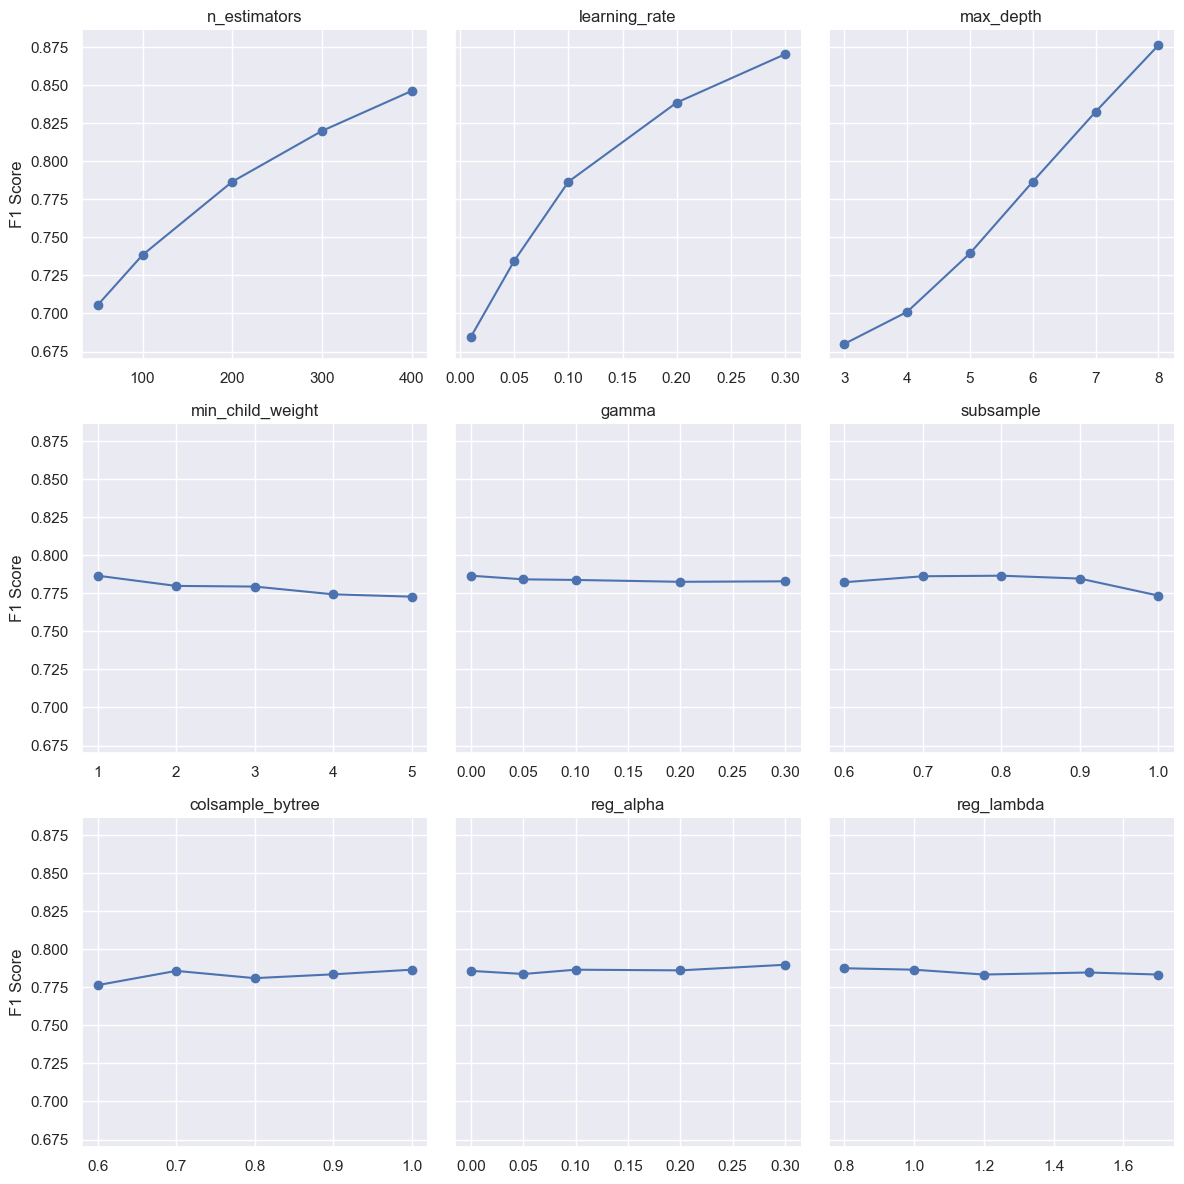

In [24]:
data = []

for param, values in param_dict.items():
    for value, score in values.items():
        data.append({'Parameter': param, 'Value': value, 'F1 Score': score})
        
df = pd.DataFrame(data)

g = sns.FacetGrid(df, col="Parameter", col_wrap=3, height=4, sharey=True, sharex=False)
g.map(plt.plot, "Value", "F1 Score", marker="o")

# Adding labels and titles
g.set_axis_labels("", "F1 Score")
g.set_titles("{col_name}")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

Significant hyperparameters:
 - learning_rate
 - max_depth
 - n_estimators
 
Redundant hyperparameters:
 - gamma
 - colsample_bytree
 - min_child_weight
 - subsample
 - reg_lambda
 - reg_alpha

In [25]:
new_param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
}

optimal_params = {'colsample_bytree': 1.0, 'gamma': 0.1, 'min_child_weight': 1, 'reg_alpha': 0.1,
                  'reg_lambda': 1, 'subsample': 0.8}

xgb_over_3 = XGBClassifier(**optimal_params, random_state=42)

xgb_over_3.fit(X_train_o, y_train_o)

# Initialize the GridSearchCV object
xgb_grid_search_2 = GridSearchCV(estimator=xgb_over_3, 
                           param_grid=new_param_grid, 
                           scoring='f1', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=1)

# Fit the grid search to the data
xgb_grid_search_2.fit(X_train_o, y_train_o)

# Print the best parameters found
print("Best parameters found: ", xgb_grid_search_2.best_params_)
print("Best F1 found: ", xgb_grid_search_2.best_score_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best parameters found:  {'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 400}
Best F1 found:  0.9146917307835946


In [26]:
y_pred_2 = xgb_grid_search_2.predict(X_test)
y_probs_2 = xgb_grid_search_2.predict_proba(X_test)[:,1]

display(pd.DataFrame(classification_report(y_test, y_pred_2,output_dict=True)).T)
print("XGBoost AUC: ", roc_auc_score(y_test, y_probs_2))

,precision,recall,f1-score,support
0,0.997994,0.976447,0.987103,8152.000000
1,0.882064,0.988981,0.932468,1452.000000
accuracy,0.978342,0.978342,0.978342,0.978342
macro avg,0.940029,0.982714,0.959785,9604.000000
weighted avg,0.980467,0.978342,0.978843,9604.000000


XGBoost AUC:  0.9970399699105428


## 4.10 Test On Unseen Data

### 4.10.1 Load Data

In [27]:
loan_test_data = pd.read_csv('../data/raw/loan_default_test_data.csv')

In [28]:
loan_test_data.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [29]:
loan_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

### 4.10.2 Data Wrangling

In [30]:
missing = pd.concat([loan_test_data.isnull().sum(), 100 * loan_test_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by=['count'], ascending = False)

,count,%
LoanID,0,0.0
Age,0,0.0
HasCoSigner,0,0.0
LoanPurpose,0,0.0
HasDependents,0,0.0
HasMortgage,0,0.0
MaritalStatus,0,0.0
EmploymentType,0,0.0
Education,0,0.0
DTIRatio,0,0.0


This is a very clean dataset where there are no missing values.

In [31]:
test_data_filtered = loan_test_data.loc[:,['LoanPurpose','HasMortgage','DTIRatio',
                                           'LoanTerm','InterestRate','NumCreditLines','MonthsEmployed',
                                          'LoanAmount','Income','Default']]

In [32]:
column_names = {'LoanPurpose':'purpose',
               'HasMortgage':'home_ownership',
               'DTIRatio':'dti',
               'LoanTerm':'term',
               'InterestRate':'int_rate',
               'NumCreditLines':'open_acc',
               'MonthsEmployed':'emp_length',
               'LoanAmount':'loan_amnt',
               'Income':'annual_inc',
               'Default':'repay_fail'}

test_data_filtered.rename(columns=column_names,inplace=True)

In [33]:
test_data_filtered.purpose.value_counts()

Business     51298
Home         51286
Education    51005
Other        50914
Auto         50844
Name: purpose, dtype: int64

In [34]:
new_labels = {'Business':'small_business',
             'Home':'home_improvement',
             'Education':'educational',
             'Other':'other',
             'Auto':'car'}

test_data_filtered.purpose.replace(new_labels,inplace=True)

In [35]:
test_data_filtered.home_ownership.value_counts()

Yes    127677
No     127670
Name: home_ownership, dtype: int64

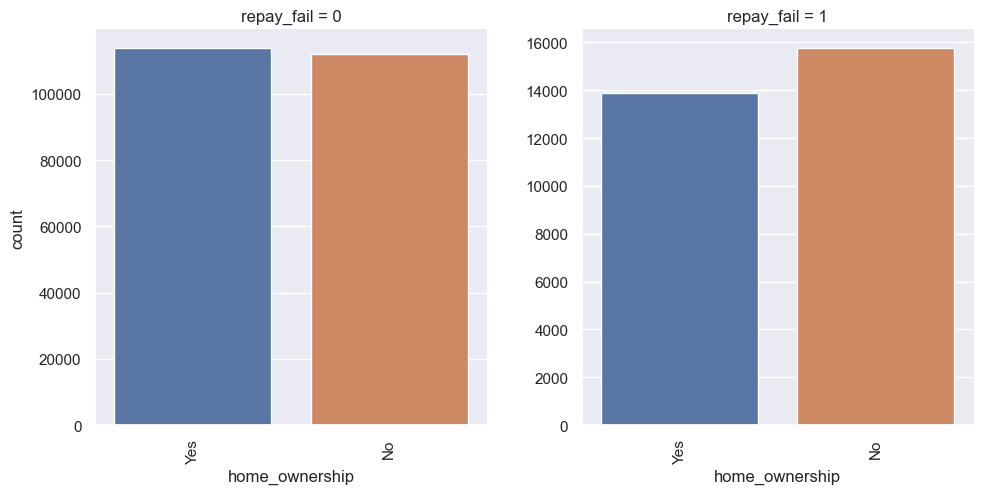

In [36]:
order = test_data_filtered['home_ownership'].value_counts().index
ax = sns.catplot(x = 'home_ownership', kind='count', col = 'repay_fail', data=test_data_filtered, sharey=False,
                order = order)
ax.set_xticklabels(rotation=90)
plt.show()

In [37]:
new_labels = {'Yes':'MORTGAGE',
             'No':'RENT'}

test_data_filtered.loc[:,'home_ownership'].replace(new_labels, inplace=True)

In [38]:
test_data_filtered.loc[:,'dti'] = test_data_filtered.loc[:,'dti'] * 100

In [39]:
test_data_filtered.loc[:,'open_acc'] = test_data_filtered.loc[:,'open_acc'].astype('float')

In [40]:
test_data_filtered.loc[:,'emp_length'] = test_data_filtered.loc[:,'emp_length'] / 12
test_data_filtered['emp_length'] = test_data_filtered['emp_length'].apply(np.floor)

test_data_filtered['emp_length'] = test_data_filtered['emp_length'].astype(int)

In [41]:
test_data_filtered.loc[:,'loan_amnt'] = test_data_filtered.loc[:,'loan_amnt'].astype('float')

In [42]:
test_data_filtered.loc[:,'annual_inc'] = test_data_filtered.loc[:,'annual_inc'].astype('float')

### 4.10.3 Missing Features

Let's import the data after exploratory data analysis to review which features are missing still.

In [43]:
explored_data = pd.read_csv('../data/interim/explored_data.csv', index_col=0)

In [44]:
explored_data.columns[~explored_data.columns.isin(test_data_filtered.columns)]

Index(['installment', 'verification_status', 'addr_state', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'annual_inc_log', 'revol_bal_log',
       'years_of_credit'],
      dtype='object')

In [45]:
installment_df = explored_data.loc[:,['installment','loan_amnt','term','int_rate']]

installment_df

,installment,loan_amnt,term,int_rate
3,85.42,2500.0,36,13.98
4,175.67,5000.0,36,15.95
5,225.58,7000.0,36,9.91
6,60.32,2000.0,36,5.42
7,116.59,3600.0,36,10.25
...,...,...,...,...
38476,99.63,3000.0,36,11.99
38477,352.88,10400.0,36,13.49
38478,250.77,16000.0,60,14.96
38479,355.99,10000.0,36,16.89


In [46]:
P = installment_df.loan_amnt
i = (installment_df.int_rate/100)/12
n = installment_df.term

var = (1+i)**n

installment_df['installment_calc'] = P*(i*var)/(var-1)

In [47]:
installment_df[['installment','installment_calc']]

,installment,installment_calc
3,85.42,85.419792
4,175.67,175.661765
5,225.58,225.574645
6,60.32,60.319663
7,116.59,116.584877
...,...,...
38476,99.63,99.628601
38477,352.88,352.876688
38478,250.77,380.303020
38479,355.99,355.980063


In [48]:
P = test_data_filtered.loan_amnt
i = (test_data_filtered.int_rate/100)/12
n = test_data_filtered.term

var = (1+i)**n

test_data_filtered['installment'] = P*(i*var)/(var-1)

In [49]:
test_data_filtered['delinq_2yrs'] = explored_data.delinq_2yrs.mode()[0]

In [50]:
test_data_filtered['inq_last_6mths'] = explored_data.inq_last_6mths.mode()[0]

In [51]:
test_data_filtered['pub_rec'] = explored_data.pub_rec.mode()[0]

In [52]:
test_data_filtered['total_acc'] = test_data_filtered.open_acc

In [53]:
test_data_filtered['years_of_credit'] = explored_data.years_of_credit.mode()[0]

In [54]:
test_data_filtered.loc[:,'annual_inc_log'] = np.log(test_data_filtered['annual_inc'])

### 4.10.4 Retrain Model

To be able to test on the unseen data and really understand the power of our model, rather than imputing the missing features of the unseen data, we can try and retrain a new model that doesn't include the three missing features that require imputing and see how it affects the original results. If the model doesn't lose lots of predicitive power, then it is safe that we don't need the features to make predictions.

In [55]:
filtered_data = explored_data.drop(columns=['verification_status', 'revol_bal', 'revol_bal_log', 'revol_util', 
                                            'addr_state', 'earliest_cr_line'])

In [56]:
explored_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38415 entries, 3 to 38480
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            38415 non-null  float64
 1   term                 38415 non-null  int64  
 2   int_rate             38415 non-null  float64
 3   installment          38415 non-null  float64
 4   emp_length           38415 non-null  int64  
 5   home_ownership       38415 non-null  object 
 6   annual_inc           38415 non-null  float64
 7   verification_status  38415 non-null  object 
 8   purpose              38415 non-null  object 
 9   addr_state           38415 non-null  object 
 10  dti                  38415 non-null  float64
 11  delinq_2yrs          38415 non-null  float64
 12  earliest_cr_line     38415 non-null  object 
 13  inq_last_6mths       38415 non-null  float64
 14  open_acc             38415 non-null  float64
 15  pub_rec              38415 non-null 

In [57]:
filtered_data.purpose.value_counts()

debt_consolidation    17901
credit_card            4970
other                  3936
home_improvement       3280
major_purchase         2071
small_business         1807
car                    1477
wedding                 908
medical                 673
moving                  559
educational             383
vacation                359
renewable_energy         91
Name: purpose, dtype: int64

In [58]:
new_labels = {'moving':'other',
             'vacation':'other',
             'renewable_energy':'other',
             'major_purchase':'other',
             'medical':'other',
             'wedding':'other'}

filtered_data.purpose.replace(new_labels, inplace=True)

In [59]:
filtered_data.purpose.value_counts()

debt_consolidation    17901
other                  8597
credit_card            4970
home_improvement       3280
small_business         1807
car                    1477
educational             383
Name: purpose, dtype: int64

In [60]:
df_encoded_2 = pd.get_dummies(filtered_data, drop_first=True)

In [61]:
#create two different dataframe of majority and minority class 
df_majority = df_encoded_2[(df_encoded_2['repay_fail']==0)]
df_minority = df_encoded_2[(df_encoded_2['repay_fail']==1)]

# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples= 32608,
                                 random_state=42)

df_upsampled_2 = pd.concat([df_minority_upsampled, df_majority])

In [62]:
X_filt = df_upsampled_2.drop(columns=['repay_fail'])
y_filt = df_upsampled_2.repay_fail

In [63]:
X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(X_filt, y_filt, test_size=0.25, random_state=42)

In [64]:
xgb_filt = XGBClassifier(random_state=42)

xgb_filt.fit(X_train_filt, y_train_filt)

# Predict on test data
y_pred_filt = xgb_filt.predict(X_test_filt)

# Optionally, get prediction probabilities
y_probs_filt = xgb_filt.predict_proba(X_test_filt)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test_filt, y_pred_filt,output_dict=True)).T)
print("XGBoost AUC: ", roc_auc_score(y_test_filt, y_probs_filt))

,precision,recall,f1-score,support
0,0.806181,0.739853,0.771594,8180.000000
1,0.758099,0.820901,0.788251,8124.000000
accuracy,0.780238,0.780238,0.780238,0.780238
macro avg,0.782140,0.780377,0.779923,16304.000000
weighted avg,0.782223,0.780238,0.779894,16304.000000


XGBoost AUC:  0.8586232693374938


In [65]:
potential_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.05, 0.1, 0.2, 0.3],
    'reg_lambda': [0.8, 1.0, 1.2, 1.5, 1.7],
    }

param_dict = {}

for param, values in potential_grid.items():
    
    optimal_params = {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 
                  'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
    
    if param not in param_dict:
        param_dict[param] = {}
    
    for value in values:
        
        optimal_params[param] = value

        xgb_temp = XGBClassifier(**optimal_params, random_state=42)

        xgb_temp.fit(X_train_filt, y_train_filt)

        xgb_pred = xgb_temp.predict(X_test_filt)

        
        param_dict[param][value] = f1_score(y_test_filt, xgb_pred)

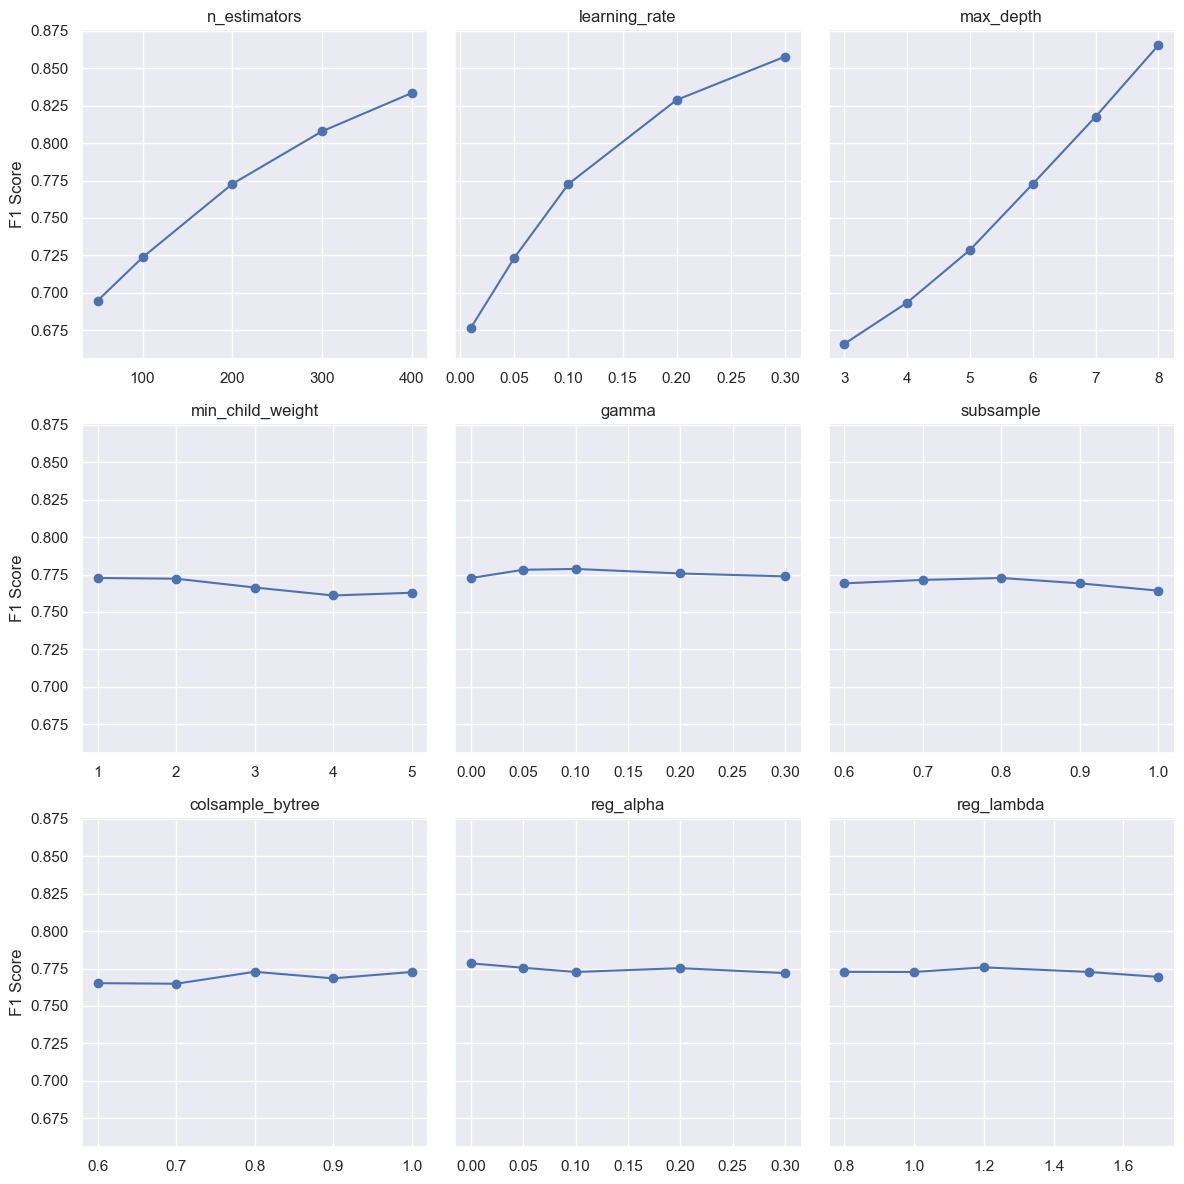

In [66]:
data = []
for param, values in param_dict.items():
    for value, score in values.items():
        data.append({'Parameter': param, 'Value': value, 'F1 Score': score})
df = pd.DataFrame(data)

g = sns.FacetGrid(df, col="Parameter", col_wrap=3, height=4, sharey=True, sharex=False)
g.map(plt.plot, "Value", "F1 Score", marker="o")

# Adding labels and titles
g.set_axis_labels("", "F1 Score")
g.set_titles("{col_name}")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [67]:
param_grid = {
    'min_child_weight': [1, 5],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

xgb_temp = XGBClassifier(random_state=42)

xgb_temp.fit(X_train_filt, y_train_filt)

# Initialize the GridSearchCV object
xgb_grid_search_filt = GridSearchCV(estimator=xgb_temp, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=1)

# Fit the grid search to the data
xgb_grid_search_filt.fit(X_train_filt, y_train_filt)

# Print the best parameters found
print("Best parameters found: ", xgb_grid_search_filt.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0.1, 'min_child_weight': 1, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}


In [68]:
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
}

optimal_params = {'colsample_bytree': 1.0, 'gamma': 0, 'min_child_weight': 1, 
                  'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}

xgb_temp = XGBClassifier(**optimal_params, random_state=42)

xgb_temp.fit(X_train_filt, y_train_filt)

# Initialize the GridSearchCV object
xgb_grid_search_filt = GridSearchCV(estimator=xgb_temp, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=1)

# Fit the grid search to the data
xgb_grid_search_filt.fit(X_train_filt, y_train_filt)

# Print the best parameters found
print("Best parameters found: ", xgb_grid_search_filt.best_params_)
print("Best F1 found: ", xgb_grid_search_filt.best_score_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best parameters found:  {'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 400}
Best F1 found:  0.9100481927447795


In [69]:
# Predict on test data
y_pred_gs_filt = xgb_grid_search_filt.predict(X_test_filt)

# Optionally, get prediction probabilities
y_probs_gs_filt = xgb_grid_search_filt.predict_proba(X_test_filt)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test_filt, y_pred_gs_filt,output_dict=True)).T)
print("XGBoost AUC: ", roc_auc_score(y_test_filt, y_probs_gs_filt))

,precision,recall,f1-score,support
0,0.987493,0.897677,0.940446,8180.000000
1,0.905616,0.988552,0.945268,8124.000000
accuracy,0.942959,0.942959,0.942959,0.942959
macro avg,0.946554,0.943115,0.942857,16304.000000
weighted avg,0.946695,0.942959,0.942849,16304.000000


XGBoost AUC:  0.9881353687766272


### 4.10.4 One-Hot Encoding

In [70]:
test_data_encoded = pd.get_dummies(test_data_filtered, drop_first=True)

In [71]:
test_data_encoded.loc[:, 'home_ownership_OWN'] = 0
test_data_encoded.loc[:, 'home_ownership_OTHER'] = 0
test_data_encoded.loc[:, 'purpose_debt_consolidation'] = 0
test_data_encoded.loc[:, 'purpose_credit_card'] = 0

### 4.10.5 Test Model

In [72]:
X_test_data = test_data_encoded.drop(columns='repay_fail')
y_test_data = test_data_encoded.repay_fail

# Reordering columns of X_test_data to match the training data's feature order
X_test_data = X_test_data[['loan_amnt', 'term', 'int_rate', 'installment', 
                           'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 
                           'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc', 
                           'annual_inc_log', 'years_of_credit', 'home_ownership_OTHER', 
                           'home_ownership_OWN', 'home_ownership_RENT', 'purpose_credit_card', 
                           'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 
                           'purpose_other', 'purpose_small_business']]

In [73]:
y_pred_test_data = xgb_grid_search_filt.predict(X_test_data)

In [74]:
y_probs_test_data = xgb_grid_search_filt.predict_proba(X_test_data)[:,1]

In [75]:
display(pd.DataFrame(classification_report(y_test_data, y_pred_test_data,output_dict=True)).T)
print("XGBoost AUC: ", roc_auc_score(y_test_data, y_probs_test_data))

,precision,recall,f1-score,support
0,0.888055,0.939254,0.912937,225694.000000
1,0.176131,0.098843,0.126625,29653.000000
accuracy,0.841659,0.841659,0.841659,0.841659
macro avg,0.532093,0.519049,0.519781,255347.000000
weighted avg,0.805380,0.841659,0.821624,255347.000000


XGBoost AUC:  0.5771639316847871


## 4.11 Retrain with Unseen Data

In [76]:
#create two different dataframe of majority and minority class 
df_majority = test_data_encoded[(test_data_encoded['repay_fail']==0)]
df_minority = test_data_encoded[(test_data_encoded['repay_fail']==1)]

# downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,
                                 n_samples= len(df_minority),
                                 random_state=42)

u_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [77]:
# u_defaulted = test_data_encoded[test_data_encoded.repay_fail == 1]
# u_non_defaulted = test_data_encoded[test_data_encoded.repay_fail == 0]

X_u = u_downsampled.drop(columns='repay_fail')
y_u = u_downsampled.repay_fail

X_u_train, X_u_test, y_u_train, y_u_test = train_test_split(X_u, y_u, test_size=0.5, random_state=42, stratify=y_u)

u_data_train = pd.concat([X_u_train, y_u_train], axis=1)
u_data_test = pd.concat([X_u_test, y_u_test], axis=1)

Performing this even split will rename the `repay_fail` column to `0` in the y datasets. Therefore, we need to rename the columns to be `repay_fail` again that way we receive any errors when training the model.

In [78]:
u_data_train.rename(columns = {0:'repay_fail'}, inplace=True)
u_data_test.rename(columns = {0:'repay_fail'}, inplace=True)

In [79]:
new_training_data = pd.concat([df_upsampled_2,u_data_train])

In [80]:
X_new = new_training_data.drop(columns='repay_fail')
y_new = new_training_data.repay_fail

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_new, y_new, test_size=0.25, random_state=42)

In [81]:
param_grid = {
    'min_child_weight': [1, 5],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

xgb_temp = XGBClassifier(random_state=42)

xgb_temp.fit(X_train_2, y_train_2)

# Initialize the GridSearchCV object
xgb_gs_temp = GridSearchCV(estimator=xgb_temp, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=1)

# Fit the grid search to the data
xgb_gs_temp.fit(X_train_2, y_train_2)

# Print the best parameters found
print("Best parameters found: ", xgb_gs_temp.best_params_)
print("Best F1 found: ", xgb_gs_temp.best_score_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0, 'min_child_weight': 1, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 1.0}
Best F1 found:  0.7206180304703045


In [82]:
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8]
}

optimal_params = {'colsample_bytree': 0.8, 'gamma': 0, 'min_child_weight': 1, 
                  'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}

xgb_temp = XGBClassifier(**optimal_params, random_state=42)

xgb_temp.fit(X_train_2, y_train_2)

# Initialize the GridSearchCV object
xgb_gs_new = GridSearchCV(estimator=xgb_temp, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=1)

# Fit the grid search to the data
xgb_gs_new.fit(X_train_2, y_train_2)

# Print the best parameters found
print("Best parameters found: ", xgb_gs_new.best_params_)
print("Best F1 found: ", xgb_gs_new.best_score_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best parameters found:  {'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 400}
Best F1 found:  0.8120095636797532


In [83]:
y_pred_new = xgb_gs_new.predict(X_test_2)

y_probs_new = xgb_gs_new.predict_proba(X_test_2)[:,1]

display(pd.DataFrame(classification_report(y_test_2, y_pred_new,output_dict=True)).T)
print("XGBoost AUC: ", roc_auc_score(y_test_2, y_probs_new))

,precision,recall,f1-score,support
0,0.850415,0.800168,0.824527,11915.000000
1,0.809627,0.857917,0.833073,11803.000000
accuracy,0.828906,0.828906,0.828906,0.828906
macro avg,0.830021,0.829043,0.828800,23718.000000
weighted avg,0.830117,0.828906,0.828779,23718.000000


XGBoost AUC:  0.9198012098818095


This score includes the data we have trained on previously. We want to see how the model will perform on only the unseen data.

In [84]:
results_dict = {}

for i in range(0,201,2):

    u_data_futile = u_data_test.sample(100)

    X_futile = u_data_futile.drop(columns='repay_fail')
    y_futile = u_data_futile.repay_fail

    X_futile = X_futile[['loan_amnt', 'term', 'int_rate', 'installment', 
           'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 
           'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc', 
           'annual_inc_log', 'years_of_credit', 'home_ownership_OTHER', 
           'home_ownership_OWN', 'home_ownership_RENT', 'purpose_credit_card', 
           'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 
           'purpose_other', 'purpose_small_business']]

    y_pred_futile = xgb_gs_new.predict(X_futile)
    y_probs_futile = xgb_gs_new.predict_proba(X_futile)[:,1]
    
    report = classification_report(y_futile, y_pred_futile, output_dict=True)
    
    iterator = iter(report.values())

    results_dict[i] = next(iterator)
    results_dict[i]['repay_fail'] = 0
    
    results_dict[i+1] = next(iterator)
    results_dict[i+1]['repay_fail'] = 1

results_df = pd.DataFrame(results_dict).T

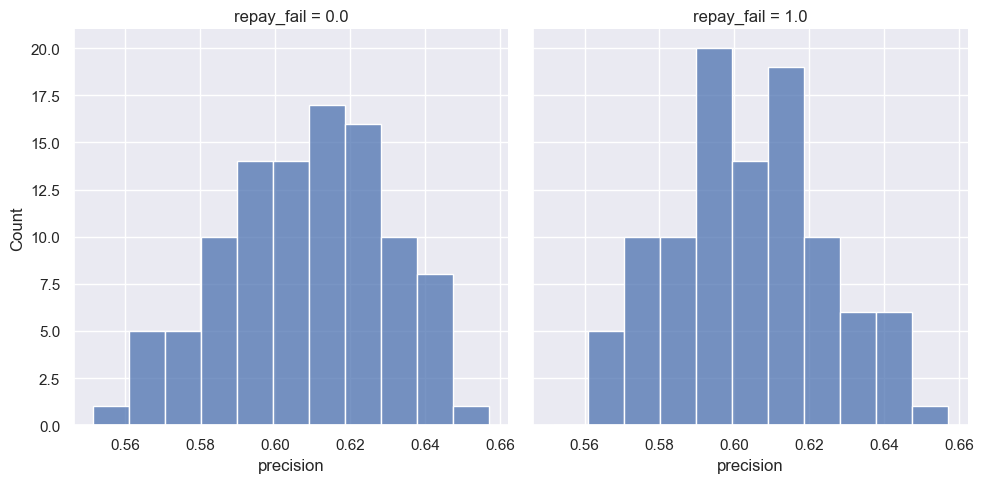

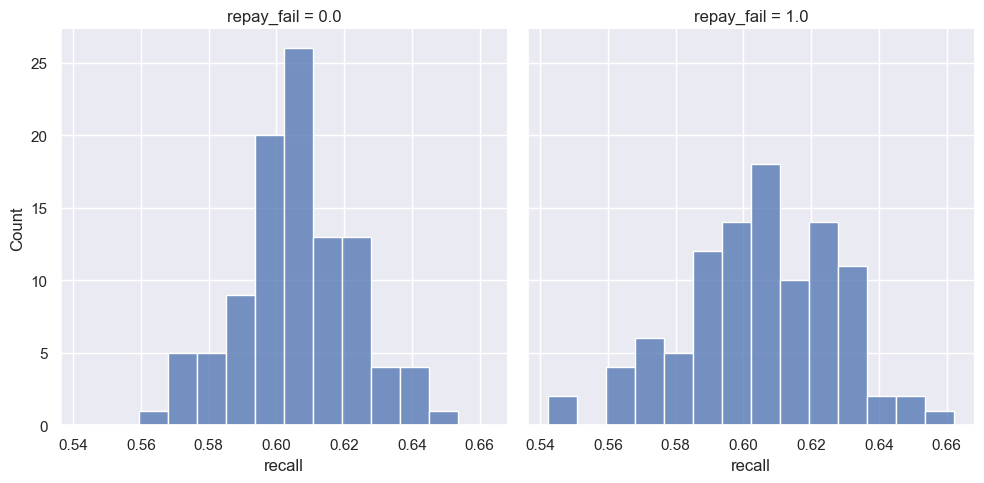

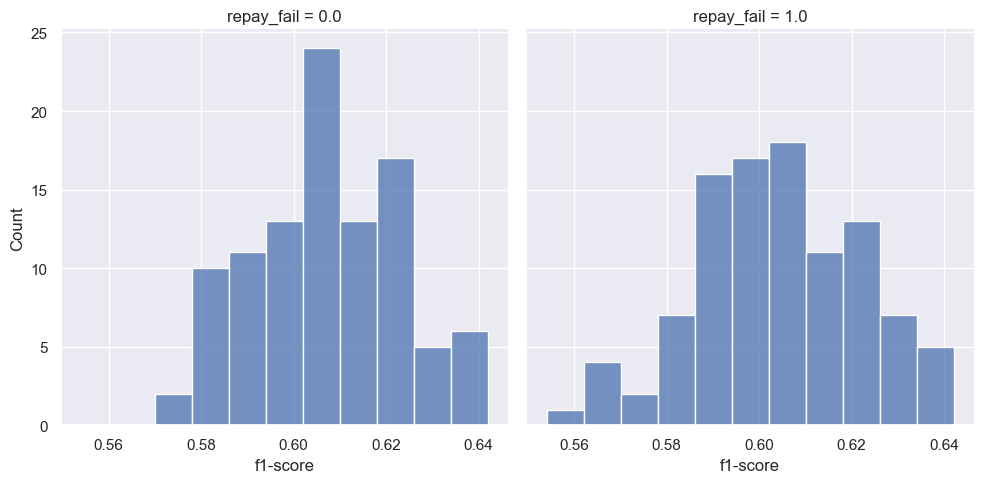

In [85]:
for col in results_df.columns:
    if col not in ['support', 'repay_fail']:
        g = sns.displot(x=col, kind='hist', col = 'repay_fail', data=results_df)
        plt.show()


References
1. https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
2. https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
3. https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/